In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import math
import seaborn as sns
%matplotlib inline

In [2]:
ps = pd.read_csv('patch_seq_log_mouse.csv')

In [3]:
ps = ps[["Date", "User", "Post patch?", "Post patch pipette R", "Nucleus sucked in?", "Notes", "Internal version", "Picogreen", "Ratio", "PCR cycles", "SM_QC_PF"]]
ps.dropna(subset = ["Post patch?", "Picogreen"], inplace = True)
ps["User"] = ps["User"].astype("category")
ps["Post patch?"] = ps["Post patch?"].astype("category")
ps["SM_QC_PF"] = ps["SM_QC_PF"].astype("category")
ps = ps[ps["SM_QC_PF"] != "cnt"]
ps = ps[ps["PCR cycles"] == 21]
ps["Date"] = pd.to_datetime(ps["Date"], format = '%y%m%d')
ps
#ps['Post patch?'].value_counts()

,Date,User,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,Picogreen,Ratio,PCR cycles,SM_QC_PF
4968,2017-04-19,P2,Outside-Out,NaN,NaN,NaN,AiV2,71,0.41,21.0,fail
4969,2017-04-19,P2,Outside-Out,NaN,NaN,NaN,AiV2,608,0.54,21.0,pass
4970,2017-04-19,P2,No-Seal,NaN,NaN,NaN,AiV2,6,1,21.0,fail
4971,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,1536,0.71,21.0,pass
4972,2017-04-19,P2,Outside-Out,NaN,NaN,NaN,AiV2,582,0.55,21.0,pass
4973,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,1154,0.81,21.0,pass
4974,2017-04-19,P2,No-Seal,NaN,NaN,NaN,AiV2,1504,0.59,21.0,pass
4975,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,1330,0.71,21.0,pass
4978,2017-04-19,P6,No-Seal,NaN,NaN,NaN,AiV2,839,0.33,21.0,fail
4979,2017-04-19,P6,No-Seal,NaN,NaN,NaN,AiV2,1292,0.51,21.0,pass


In [4]:
ps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1847 entries, 4968 to 7596
Data columns (total 11 columns):
Date                    1847 non-null datetime64[ns]
User                    1847 non-null category
Post patch?             1847 non-null category
Post patch pipette R    240 non-null float64
Nucleus sucked in?      240 non-null object
Notes                   1728 non-null object
Internal version        1841 non-null object
Picogreen               1847 non-null object
Ratio                   1846 non-null object
PCR cycles              1847 non-null float64
SM_QC_PF                1847 non-null category
dtypes: category(3), datetime64[ns](1), float64(2), object(5)
memory usage: 135.5+ KB


In [5]:
def get_count(x):    
    count = x["Post patch?"].count()
    return count

def calc_pct(part,total):
    pct = float(get_count(part)) / get_count(total)
    return pct

In [6]:
def nucleated(x):
    nucleus = x[(x["Post patch?"] == "Nucleated") | (((x["Post patch?"] == "nucleus_visible") | (x["Post patch?"] == "nucleus_present")) & (x["Post patch pipette R"] >= 501))]
    return nucleus

def partial_nucleated(y):
    partial = y[(y["Post patch?"] == 'Partial-Nucleus') | (((y['Post patch?'] == 'nucleus_present') | (y['Post patch?'] == 'nucleus_visible')) & (y["Post patch pipette R"] <= 500))]
    return partial

def outside_out(z):
    outside = z[(z["Post patch?"] == 'Outside-Out') | (((z['Post patch?'] == 'nucleus_absent') | (z['Post patch?'] == 'no_nuclues_visible')) & (z['Post patch pipette R'] >= 501))]
    return outside

def no_seal(w): 
    no = w[(w["Post patch?"] == 'No-Seal') | (((w['Post patch?'] == 'nucleus_absent') | (w['Post patch?'] == 'no_nucleus_visible')) & (w['Post patch pipette R'] <= 500))]
    return no
    
def entire_cell(v):
    entire = v[(v["Post patch?"] == 'Entire-Cell') | (v['Post patch?'] == 'entire_cell')]
    return entire
    
def pass_only(df):
    pas = df[df["SM_QC_PF"] == "pass"]
    return pas

In [8]:
nuc = nucleated(ps)
nuc["post patch class"] = "Nucleated"

part_nuc = partial_nucleated(ps)
part_nuc["post patch class"] = "Partial nucleated"

out_out = outside_out(ps)
out_out["post patch class"] = "Outisde out"

noSeal = no_seal(ps)
noSeal["post patch class"] = "No seal"

entirecell = entire_cell(ps)
entirecell["post patch class"] = "Entire Cell"

frames = [nuc, part_nuc, out_out, noSeal, entirecell]
ps2 = pd.concat(frames)
ps2

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

,Date,User,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,Picogreen,Ratio,PCR cycles,SM_QC_PF,post patch class
4971,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,1536,0.71,21.0,pass,Nucleated
4973,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,1154,0.81,21.0,pass,Nucleated
4975,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,1330,0.71,21.0,pass,Nucleated
4988,2017-04-20,P1,Nucleated,NaN,NaN,NaN,AiV2,890,0.66,21.0,pass,Nucleated
4997,2017-04-20,P1,Nucleated,NaN,NaN,NaN,AiV2,1023,0.65,21.0,pass,Nucleated
5009,2017-04-20,P2,Nucleated,NaN,NaN,NaN,AiV2,1701,0.74,21.0,pass,Nucleated
5022,2017-04-21,P1,Nucleated,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed",AiV2,1211,0.81,21.0,pass,Nucleated
5026,2017-04-21,P2,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,1272,0.61,21.0,pass,Nucleated
5027,2017-04-21,P2,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,775,0.75,21.0,pass,Nucleated
5035,2017-04-21,P2,Nucleated,NaN,NaN,NaN,AiV2,1134,0.78,21.0,pass,Nucleated


In [9]:
ps2["Picogreen"] = pd.to_numeric(ps2["Picogreen"].str.replace(' ',''), errors ='force')
ps2["post patch class"] = ps2["post patch class"].astype("category")
ps2['Internal version'] = ps2['Internal version'].astype('category')
ps2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1845 entries, 4971 to 7588
Data columns (total 12 columns):
Date                    1845 non-null datetime64[ns]
User                    1845 non-null category
Post patch?             1845 non-null category
Post patch pipette R    239 non-null float64
Nucleus sucked in?      239 non-null object
Notes                   1726 non-null object
Internal version        1839 non-null category
Picogreen               1845 non-null float64
Ratio                   1844 non-null object
PCR cycles              1845 non-null float64
SM_QC_PF                1845 non-null category
post patch class        1845 non-null category
dtypes: category(5), datetime64[ns](1), float64(3), object(3)
memory usage: 124.6+ KB


In [12]:
ps2 = ps2[ps2["Picogreen"] < 10000]
ps2 = ps2[ps2['Internal version'] != 'AiV2-50uM alexa 489']
ps2['Internal version'].value_counts()

AiV2                   1368
AiV2-50uM alexa 488     467
dtype: int64

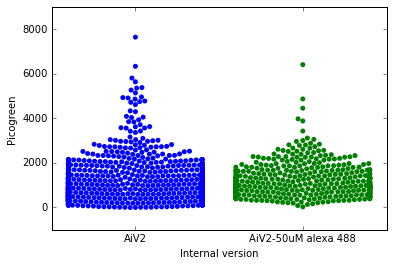

In [13]:
#Internal = ps2.groupby(['Internal version'])
#standard = ps2[ps2['Internal version'] == 'AiV2']
#standard
sns.swarmplot(x='Internal version', y='Picogreen', data=ps2)
#sns.violinplot(x='post patch class', y='Picogreen', data=ps2)

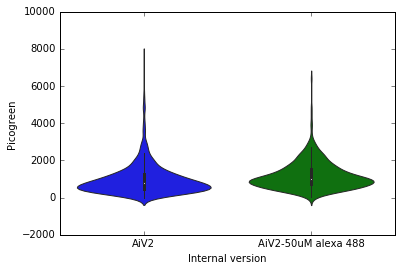

In [15]:
sns.violinplot(x='Internal version', y='Picogreen', data=ps2)